# W2D1 Tutorial 8: Non-Stationarity in the EVT-framework

#### __Week 2, Day 4, Extremes & Vulnerability__
##### __Content creators:__ Matthias Aengenheyster, Joeri Reinders
##### __Content reviewers:__ TBD
##### __Content editors:__ TBD
##### __Production editors:__ TBD
##### __Our 2023 Sponsors:__ TBD

## Tutorial Objectives:

In the 8th tutorial we include non-stationary into our GEV parameters to get a better model fit to our sea level heights from Washington DC.

By the end of the tutorial you will be able to:
1. Fit a GEV distribution to a non-stationary record by including a time-dependent parameter.
2. Examine the different fits for models with different time-dependent parameters (e.g. location, scale or shape).
3. Compute effective return levels from our non-stationary GEV model.

## Setup

In [ ]:
# Installs

In [ ]:
# !pip install -q condacolab
# import condacolab
# condacolab.install()

In [ ]:
# #install dependencies - taken from <Yosmely Bermúdez> comments for Tutorial 6
# # We need this to install eigen which is needed for SDFC to install correctly
# !mamba install eigen numpy matplotlib seaborn pandas cartopy scipy texttable intake xarrayutils xmip cf_xarray intake-esm
# !pip install -v https://github.com/yrobink/SDFC/archive/master.zip#subdirectory=python
# !pip install https://github.com/njleach/mystatsfunctions/archive/master.zip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats

import extremes_functions as ef
from mystatsfunctions import OLSE,LMoments
import SDFC as sd

gev = stats.genextreme

In [3]:
def estimate_return_level(quantile,model):
    loc, scale, shape = model.loc, model.scale, model.shape
    level = loc - scale / shape * (1 - (-np.log(quantile))**(-shape))
    return level

In [4]:
import os, pooch

fname = 'WashingtonDCSSH1930-2022.csv'
if not os.path.exists(fname):
    url = "https://osf.io/4zynp/download"
    fname = pooch.retrieve(url, known_hash=None)

data = pd.read_csv(fname, index_col=0).set_index('years')

As before, start by visually inspecting the data: Create a plot of the recorded data over time.

Text(0, 0.5, 'sea surface height')

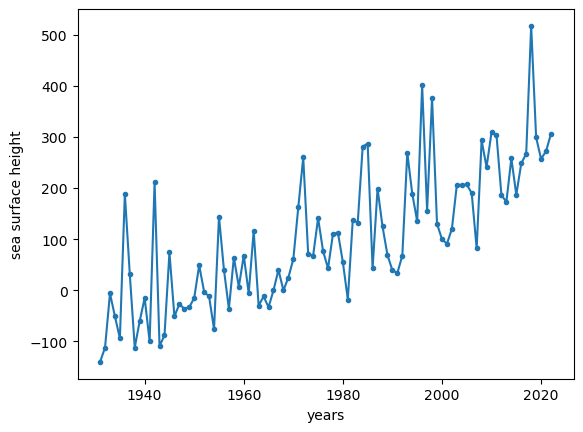

In [5]:
data.ssh.plot(linestyle='-',marker='.')
plt.ylabel('sea surface height')

Also, fit a stationary GEV distribution to the data and print the resulting fit:

In [6]:
fit, model = ef.fit_return_levels_sdfc(data.ssh.values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=10,full=True,model=True)

In [7]:
model

+-----------+--------+------------+---------+----------------+----------------+
| GEV (mle) |  Link  |    Type    |  coef   | Quantile 0.025 | Quantile 0.975 |
+===========+========+============+=========+================+================+
| loc       | IdLink | Stationary | 45.247  | 24.260         | 82.145         |
+-----------+--------+------------+---------+----------------+----------------+
| scale     | IdLink | Stationary | 117.009 | 113.782        | 130.847        |
+-----------+--------+------------+---------+----------------+----------------+
| shape     | IdLink | Stationary | -0.115  | -0.346         | -0.047         |
+-----------+--------+------------+---------+----------------+----------------+

The following figure combines the QQ-plot (recall previous tutorials), the comparison of modelled and empirical probability density functions, and the fitted return level plot.

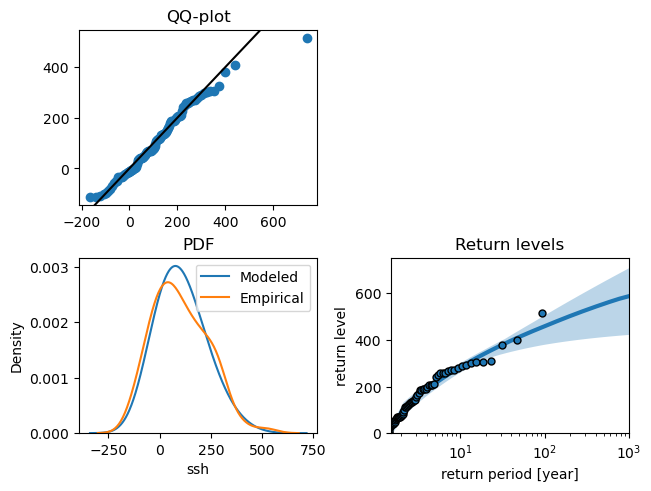

In [8]:
fig, axs = plt.subplots(2,2,constrained_layout=True)
ax = axs.flatten()

x = np.linspace(0,1,100)
ax[0].plot(
    gev.ppf(x, -fit.xi.mean().values, loc=fit.mu.mean().values, scale=fit.sigma.mean().values), 
    np.quantile(data.ssh,x),
    'o')
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([min(xlim[0],ylim[0]),max(xlim[1],ylim[1])],[min(xlim[0],ylim[0]),max(xlim[1],ylim[1])],'k')

ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)


x = np.linspace(data.ssh.min()-200, data.ssh.max()+200, 1000)
ax[2].plot(x,gev.pdf(x, -fit.xi.mean().values, loc=fit.mu.mean().values, scale=fit.sigma.mean().values), label='Modeled')
sns.kdeplot(data.ssh,ax=ax[2],label='Empirical')
ax[2].legend()

ef.plot_levels_from_obj(fit,alpha=0.95,ax=ax[3])
ax[3].set_xlim(1.5,1000)
ax[3].set_ylim(0,None)

ax[0].set_title('QQ-plot')
ax[2].set_title('PDF')
ax[3].set_title('Return levels')

ax[1].remove()

Use the function estimate_return_level to compute the 100-year return level:

In [9]:
print('100-year return level: %.2f' % estimate_return_level(1-1/100,model).mean())

100-year return level: 462.88


we can make our GEV model non-stationary adding a time component to the GEV parameters. 

That means that our parameters change as time changes… Or... we could make them dependent on global air 
temperature for example. The simplest version of a non-stationary GEV model is by adding a linear time
component to the location parameter. Instead of our location parameter being (for example) “100” it would
be a linear function time ( time*1.05+80” ). The location parameter now becomes larger as time increases.
We can incorporate this into our fit through the option of c_loc.

We cannot use the function ef.fit_return_levels_sdfc anymore because it does not support non-stationary parameters. However, under the hood it uses the SDFC functionality, which we now use directly

In [65]:
# initialize a GEV distribution:
law_ns = sd.GEV(n_bootstrap=10)
# fit the GEV to the data, while specifying that the location parameter ('loc') is meant to be a covariate ('_c') of the time axis (data.index)
law_ns.fit(data.ssh.values, c_loc = np.arange(data.index.size))

In [66]:
law_ns

+-----------+--------+------------+------------------+----------------------+------------------+
| GEV (mle) |  Link  |    Type    |       coef       |    Quantile 0.025    |  Quantile 0.975  |
+===========+========+============+==================+======================+==================+
| loc       | IdLink | Covariate  | [-103.002, 3.63] | [-128.348, -100.096] | [-34.827, 4.028] |
+-----------+--------+------------+------------------+----------------------+------------------+
| scale     | IdLink | Stationary | 61.414           | 50.862               | 499.344          |
+-----------+--------+------------+------------------+----------------------+------------------+
| shape     | IdLink | Stationary | 0.059            | -0.032               | 171.069          |
+-----------+--------+------------+------------------+----------------------+------------------+

Now the location parameter is of type "Covariate" (that is, it *covaries* with the array we provided to c_loc), and it now consists of *two* coefficients (intercept and slope) of the linear relationship between the location parameter and the provided array.

As you can see we related the location parameter to an array which is just 1,2,3,4,5,6 etc. - that is a *linear relationship*.
When instead we would have used provided an exponential function of time (such as 1,2,4,8,16, by setting c_loc = np.exp(np.arange(data.index.size)/data.index.size)) etc (exponential growth) we would create an *exponential relationship*.

If we had squared it (c_loc = np.arange(data.index.size)**2) we would have created a *quadratic relationship*

You can use all sorts of relations AND you can
apply it to all the parameters (or multiple) through c_scale and c_shape. You could also, for example,
related it to the global mean CO2 concentration (rather than simply time), which might make the fit even better. 

Since the location parameter is not dependent on time we cannot construct a return level/return period
plot like we did last class… As there are now 93 different plots, one for each year. What we can however
do, which is also visually attractive, is compute the level of the 100-year event over time and plot that
onto our SSH record. We call
this the “effective return levels”. 


Text(0, 0.5, 'annual maximum sea level anomaly (mm)')

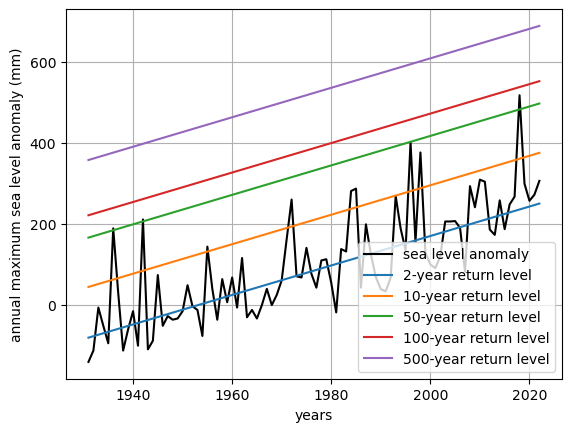

In [77]:
data.ssh.plot(c='k',label='sea level anomaly')
plt.plot(data.index,estimate_return_level(1-1/2,law_ns),label='2-year return level')
plt.plot(data.index,estimate_return_level(1-1/10,law_ns),label='10-year return level')
plt.plot(data.index,estimate_return_level(1-1/50,law_ns),label='50-year return level')
plt.plot(data.index,estimate_return_level(1-1/100,law_ns),label='100-year return level')
plt.plot(data.index,estimate_return_level(1-1/500,law_ns),label='500-year return level')
plt.legend()
plt.grid(True)
plt.ylabel('annual maximum sea level anomaly (mm)')

You can assess the fit of your model by looking at the AIC level of your model fit. 
The Akaike Information Criterion (AIC), https://en.wikipedia.org/wiki/Akaike_information_criterion is useful to estimate how well the model fits the data, while preferring simpler models with fewer free parameters. The lower the AIC number the better the fit. Below a simple function is defined that computes the AIC for a given fitted *model*.

In [73]:
def compute_aic(model):
    return 2 * len(model.coef_) + 2 * model.info.optim_result.fun

In [74]:
compute_aic(model)

1161.2588604785976

In [75]:
compute_aic(law_ns)

1062.453526638374

You can see that AIC is lower for the model that has the location parameter as a *covariate* - this suggest this model fits the data better

## Exercise: Scale and/or shape as function of time
You have seen above how to make the location parameter a function of time, by providing the keyword c_loc keyword to the fit() function.
1. Now repeat this procedure, making scale, shape or both a function of time. You need to initialize a new GEV instance, call it e.g. law_ns_scale = sd.GEV() and then call the .fit() function similarly to above, by replacing c_loc with c_scale and/or c_shape.
2. Plot the effective return levels by providing your fitted model to the function estimate_return_level (as above). Does the model fit the data better? the same? worse?
3. Compute the AIC for your new fits. Is your expectation from (2) met?

### student

In [78]:
...

Ellipsis

### solution

In [16]:
law_ns_scale = sd.GEV()
law_ns_scale.fit(data.ssh.values, c_scale = np.arange(data.index.size))

Text(0.5, 1.0, 'Scale as function of time')

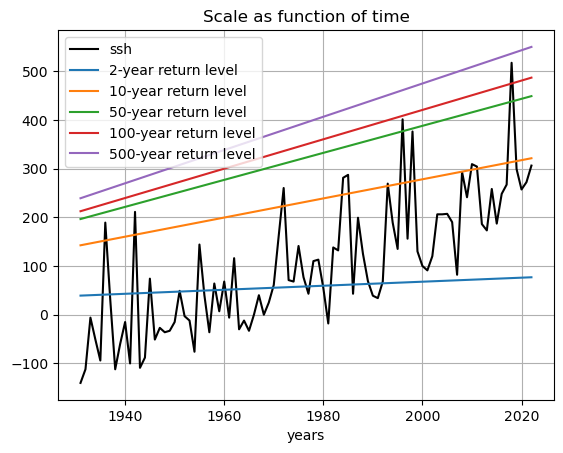

In [17]:

data.ssh.plot(c='k')
plt.plot(data.index,estimate_return_level(1-1/2,law_ns_scale),label='2-year return level')
plt.plot(data.index,estimate_return_level(1-1/10,law_ns_scale),label='10-year return level')
plt.plot(data.index,estimate_return_level(1-1/50,law_ns_scale),label='50-year return level')
plt.plot(data.index,estimate_return_level(1-1/100,law_ns_scale),label='100-year return level')
plt.plot(data.index,estimate_return_level(1-1/500,law_ns_scale),label='500-year return level')
plt.legend()
plt.grid(True)
plt.title('Scale as function of time')

### scale as function of time

In [18]:
law_ns_shape = sd.GEV()
law_ns_shape.fit(data.ssh.values, c_shape = np.arange(data.index.size))

Text(0.5, 1.0, 'Shape as function of time')

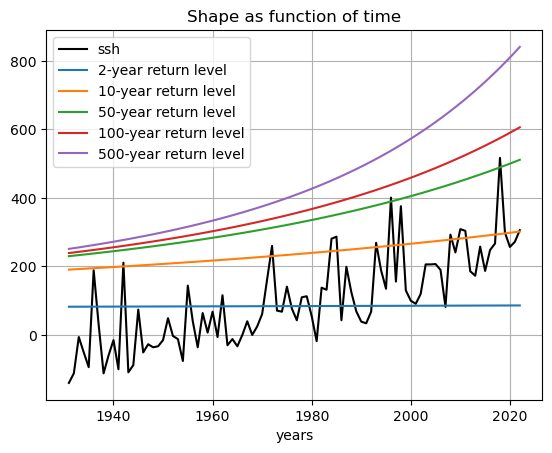

In [19]:
data.ssh.plot(c='k')
plt.plot(data.index,estimate_return_level(1-1/2,law_ns_shape),label='2-year return level')
plt.plot(data.index,estimate_return_level(1-1/10,law_ns_shape),label='10-year return level')
plt.plot(data.index,estimate_return_level(1-1/50,law_ns_shape),label='50-year return level')
plt.plot(data.index,estimate_return_level(1-1/100,law_ns_shape),label='100-year return level')
plt.plot(data.index,estimate_return_level(1-1/500,law_ns_shape),label='500-year return level')
plt.legend()
plt.grid(True)
plt.title('Shape as function of time')

### location and scale as function of time

In [20]:
law_ns_loc_scale = sd.GEV()
law_ns_loc_scale.fit(data.ssh.values, c_loc = np.arange(data.index.size), c_scale = np.arange(data.index.size))

Text(0.5, 1.0, 'Location and scale as function of time')

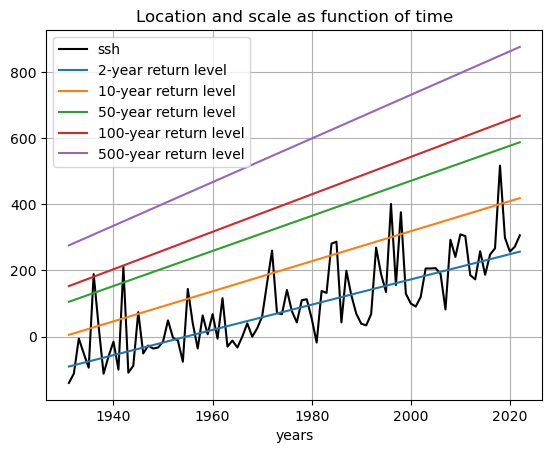

In [21]:
data.ssh.plot(c='k')
plt.plot(data.index,estimate_return_level(1-1/2,law_ns_loc_scale),label='2-year return level')
plt.plot(data.index,estimate_return_level(1-1/10,law_ns_loc_scale),label='10-year return level')
plt.plot(data.index,estimate_return_level(1-1/50,law_ns_loc_scale),label='50-year return level')
plt.plot(data.index,estimate_return_level(1-1/100,law_ns_loc_scale),label='100-year return level')
plt.plot(data.index,estimate_return_level(1-1/500,law_ns_loc_scale),label='500-year return level')
plt.legend()
plt.grid(True)
plt.title('Location and scale as function of time')

In [22]:
aics = pd.Series(
    index = ['Location','Scale','Shape','Location and Scale'],
    data  = [compute_aic(law_ns), compute_aic(law_ns_scale), compute_aic(law_ns_shape), compute_aic(law_ns_loc_scale)]
    )

aics

Location              1062.453527
Scale                 1157.801560
Shape                 1161.219576
Location and Scale    1061.982856
dtype: float64